# 🚇 Tunnel Squeezing Classification Analysis

## Objective
Develop a robust ML classification model to predict tunnel squeezing class (`Class 1, 2, or 3`) based on:
- **D (m)**: Tunnel diameter
- **H (m)**: Overburden depth
- **Q**: Rock mass quality index
- **K (MPa)**: Rock mass stiffness

### Target Classes:
| Class | Description | Strain Criterion |
|---|---|---|
| 1 | Non-squeezing | ε < 1% |
| 2 | Minor squeezing | 1% ≤ ε < 2.5% |
| 3 | Severe-Extreme | ε ≥ 2.5% |

### Enhancements in this Analysis:
1. **SMOTE**: Compare model performance with/without Synthetic Minority Over-sampling.
2. **Advanced Hyperparameter Tuning**: Extended GridSearchCV.
3. **Multi-class ROC-AUC Curves**.
4. **Model Comparison Dashboard**.

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, f1_score, precision_score, recall_score
)
from sklearn.multiclass import OneVsRestClassifier

# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


---
## 2. Load and Clean Data

In [2]:
df = pd.read_csv('tunnel.csv')
print(f"Original dataset shape: {df.shape}")
display(df.head())

Original dataset shape: (117, 7)


,No,D (m),H(m),Q,K(MPa),ε (%),Class
0,1,6.0,150.0,0.4,26.19,0.42,1
1,2,6.0,200.0,0.4,20.00,0.75,1
2,3,5.8,350.0,0.5,2.53,7.90,3
3,4,4.8,225.0,3.6,1000.00,0.06,1
4,5,4.8,340.0,1.8,500.00,0.40,1


In [3]:
# Check for anomalies: K(MPa) should not be 0 for rock
anomalous_rows = df[df['K(MPa)'] <= 0]
print(f"Rows with K <= 0: {len(anomalous_rows)}")
display(anomalous_rows)

# Remove anomalous rows
df_clean = df[df['K(MPa)'] > 0].copy()
print(f"\nCleaned dataset shape: {df_clean.shape}")

Rows with K <= 0: 3


,No,D (m),H(m),Q,K(MPa),ε (%),Class
114,115,5.4,80.0,93.50,0.0,0.0,1
115,116,5.4,190.0,7.45,0.0,0.0,1
116,117,5.4,130.0,1.53,0.0,0.0,1



Cleaned dataset shape: (114, 7)


In [4]:
# Descriptive statistics
df_clean.describe()

,No,D (m),H(m),Q,K(MPa),ε (%),Class
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,57.500000,6.376316,385.387719,0.560079,384.263070,4.028509,2.263158
std,33.052988,2.380240,205.863622,1.644258,718.029883,5.499740,0.852406
min,1.000000,2.500000,52.000000,0.001000,2.530000,0.020000,1.000000
25%,29.250000,4.600000,225.000000,0.018500,9.810000,0.777500,1.000000
50%,57.500000,5.800000,331.000000,0.058000,26.200000,2.610000,3.000000
75%,85.750000,8.700000,580.000000,0.333000,649.500000,4.560000,3.000000
max,114.000000,13.000000,850.000000,15.000000,5324.000000,36.730000,3.000000


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Class Distribution

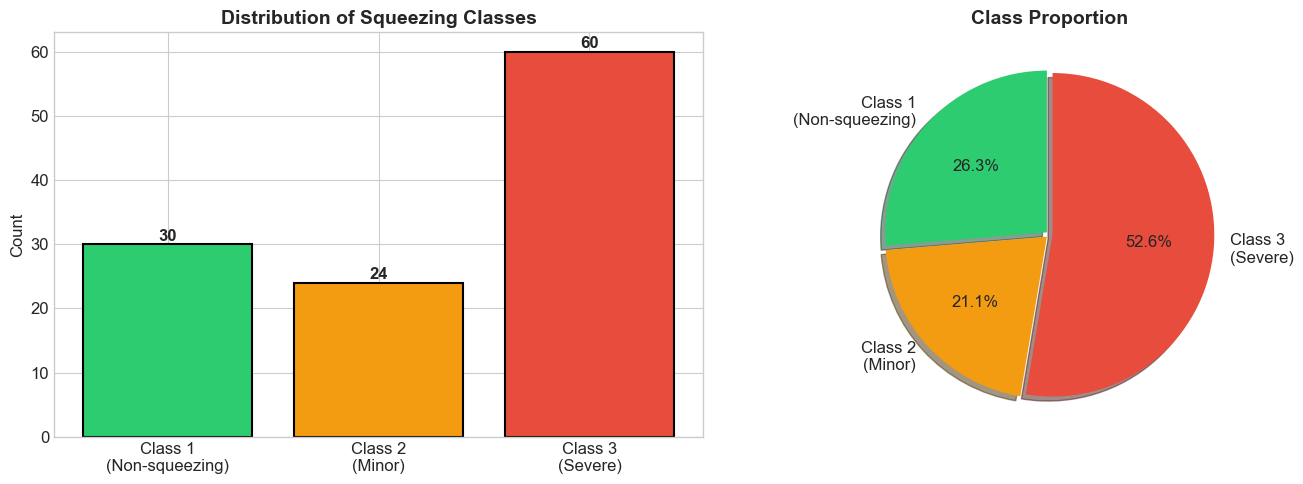


⚠️ Note: Class imbalance detected. SMOTE will be applied to address this.


In [5]:
class_counts = df_clean['Class'].value_counts().sort_index()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
labels = ['Class 1\n(Non-squeezing)', 'Class 2\n(Minor)', 'Class 3\n(Severe)']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(labels, class_counts.values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Distribution of Squeezing Classes', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, explode=(0.02, 0.02, 0.02), shadow=True)
axes[1].set_title('Class Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Class imbalance detected. SMOTE will be applied to address this.")

### 3.2 Feature Distributions by Class

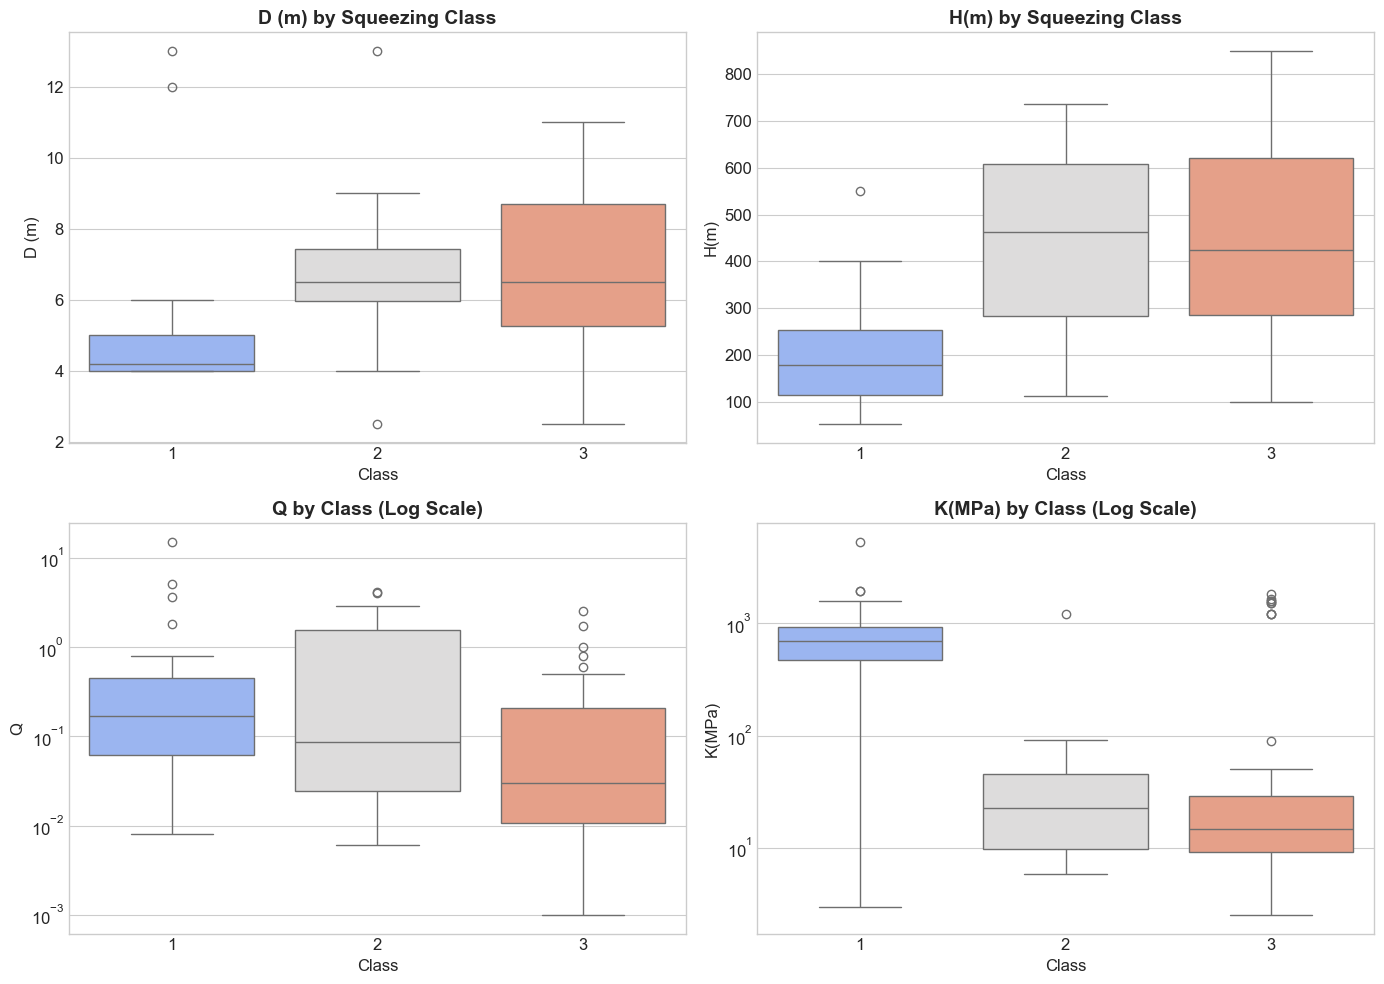

In [6]:
features = ['D (m)', 'H(m)', 'Q', 'K(MPa)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='Class', y=feature, data=df_clean, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'{feature} by Squeezing Class', fontweight='bold')
    if feature in ['Q', 'K(MPa)']:
        axes[i].set_yscale('log')
        axes[i].set_title(f'{feature} by Class (Log Scale)', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.3 Correlation Heatmap

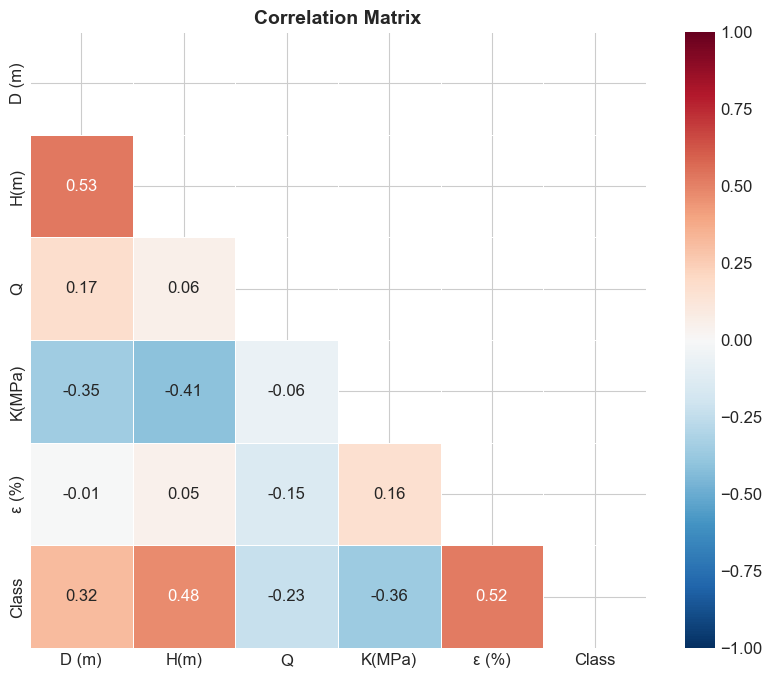

In [7]:
plt.figure(figsize=(10, 8))
corr = df_clean[features + ['ε (%)', 'Class']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5,
            mask=mask, vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix', fontweight='bold', fontsize=14)
plt.show()

### 3.4 Pairplot

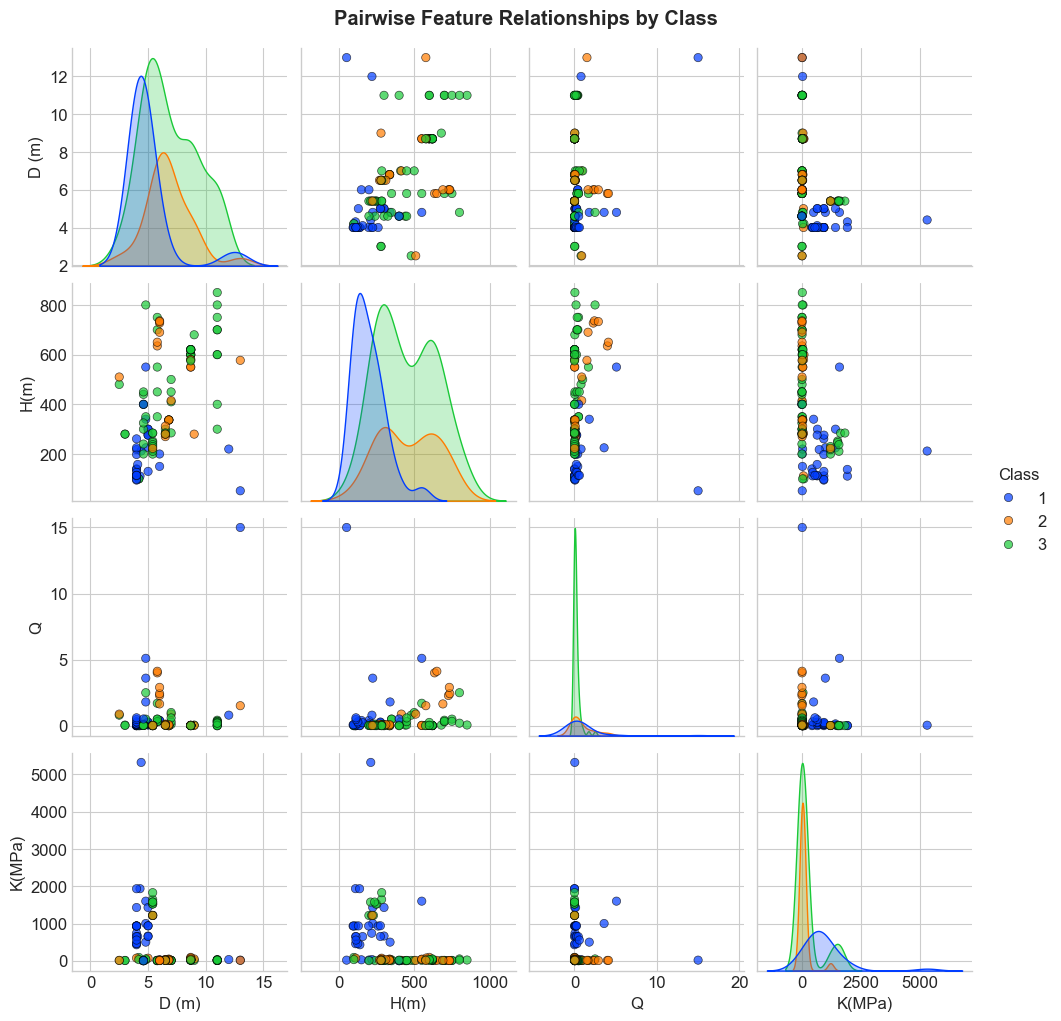

In [8]:
g = sns.pairplot(df_clean[features + ['Class']], hue='Class', palette='bright',
                 diag_kind='kde', plot_kws={'alpha': 0.7, 'edgecolor': 'k'})
g.fig.suptitle('Pairwise Feature Relationships by Class', y=1.02, fontweight='bold')
plt.show()

---
## 4. Data Preprocessing

In [9]:
# Define Features and Target
X = df_clean[['D (m)', 'H(m)', 'Q', 'K(MPa)']].values
y = df_clean['Class'].values

# Train-Test Split (Stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 91 samples
Test set: 23 samples


### Apply SMOTE to Training Data

In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set size: {len(y_train)}")
print(f"SMOTE training set size: {len(y_train_smote)}")
print(f"\nClass distribution after SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for c, cnt in zip(unique, counts):
    print(f"  Class {c}: {cnt}")

Original training set size: 91
SMOTE training set size: 144

Class distribution after SMOTE:
  Class 1: 48
  Class 2: 48
  Class 3: 48


---
## 5. Model Training and Comparison

We will train multiple models with and without SMOTE to compare performance.

In [11]:
# Store results for comparison
results = []

def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name, smote_used):
    """Train, evaluate, and store results for a model."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    acc = accuracy_score(y_te, y_pred)
    f1_macro = f1_score(y_te, y_pred, average='macro')
    f1_weighted = f1_score(y_te, y_pred, average='weighted')
    
    results.append({
        'Model': model_name,
        'SMOTE': smote_used,
        'Accuracy': acc,
        'F1 (Macro)': f1_macro,
        'F1 (Weighted)': f1_weighted
    })
    
    return model, y_pred

### 5.1 Support Vector Machine (SVM)

In [12]:
# Extended hyperparameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 500],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Train SVM without SMOTE
print("Training SVM (No SMOTE)...")
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid,
                        cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
svm_grid.fit(X_train_scaled, y_train)
print(f"Best SVM params (No SMOTE): {svm_grid.best_params_}")
svm_model, svm_pred = evaluate_model(svm_grid.best_estimator_, X_train_scaled, y_train,
                                      X_test_scaled, y_test, 'SVM', 'No')

Training SVM (No SMOTE)...
Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best SVM params (No SMOTE): {'C': 500, 'gamma': 1, 'kernel': 'rbf'}


In [13]:
# Train SVM with SMOTE
print("Training SVM (With SMOTE)...")
svm_grid_smote = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid,
                               cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
svm_grid_smote.fit(X_train_smote, y_train_smote)
print(f"Best SVM params (SMOTE): {svm_grid_smote.best_params_}")
svm_model_smote, svm_pred_smote = evaluate_model(svm_grid_smote.best_estimator_,
                                                  X_train_smote, y_train_smote,
                                                  X_test_scaled, y_test, 'SVM', 'Yes')

Training SVM (With SMOTE)...
Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best SVM params (SMOTE): {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


### 5.2 Random Forest

In [14]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train RF without SMOTE
print("Training Random Forest (No SMOTE)...")
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                       cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)
print(f"Best RF params (No SMOTE): {rf_grid.best_params_}")
rf_model, rf_pred = evaluate_model(rf_grid.best_estimator_, X_train_scaled, y_train,
                                    X_test_scaled, y_test, 'Random Forest', 'No')

Training Random Forest (No SMOTE)...
Fitting 5 folds for each of 180 candidates, totalling 900 fits


Best RF params (No SMOTE): {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [15]:
# Train RF with SMOTE
print("Training Random Forest (With SMOTE)...")
rf_grid_smote = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                              cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
rf_grid_smote.fit(X_train_smote, y_train_smote)
print(f"Best RF params (SMOTE): {rf_grid_smote.best_params_}")
rf_model_smote, rf_pred_smote = evaluate_model(rf_grid_smote.best_estimator_,
                                                X_train_smote, y_train_smote,
                                                X_test_scaled, y_test, 'Random Forest', 'Yes')

Training Random Forest (With SMOTE)...
Fitting 5 folds for each of 180 candidates, totalling 900 fits


Best RF params (SMOTE): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


### 5.3 Gradient Boosting

In [16]:
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

# Train GB without SMOTE
print("Training Gradient Boosting (No SMOTE)...")
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid,
                       cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
gb_grid.fit(X_train_scaled, y_train)
print(f"Best GB params (No SMOTE): {gb_grid.best_params_}")
gb_model, gb_pred = evaluate_model(gb_grid.best_estimator_, X_train_scaled, y_train,
                                    X_test_scaled, y_test, 'Gradient Boosting', 'No')

Training Gradient Boosting (No SMOTE)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


Best GB params (No SMOTE): {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [17]:
# Train GB with SMOTE
print("Training Gradient Boosting (With SMOTE)...")
gb_grid_smote = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid,
                              cv=StratifiedKFold(5), scoring='f1_macro', n_jobs=-1, verbose=1)
gb_grid_smote.fit(X_train_smote, y_train_smote)
print(f"Best GB params (SMOTE): {gb_grid_smote.best_params_}")
gb_model_smote, gb_pred_smote = evaluate_model(gb_grid_smote.best_estimator_,
                                                X_train_smote, y_train_smote,
                                                X_test_scaled, y_test, 'Gradient Boosting', 'Yes')

Training Gradient Boosting (With SMOTE)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


Best GB params (SMOTE): {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}


---
## 6. Model Comparison Dashboard

In [18]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Model,SMOTE,Accuracy,F1 (Macro),F1 (Weighted)
5,Gradient Boosting,Yes,0.913043,0.914141,0.916337
3,Random Forest,Yes,0.913043,0.914141,0.916337
2,Random Forest,No,0.826087,0.765993,0.809618
4,Gradient Boosting,No,0.826087,0.811111,0.826087
0,SVM,No,0.782609,0.766667,0.779710
1,SVM,Yes,0.739130,0.742424,0.741765


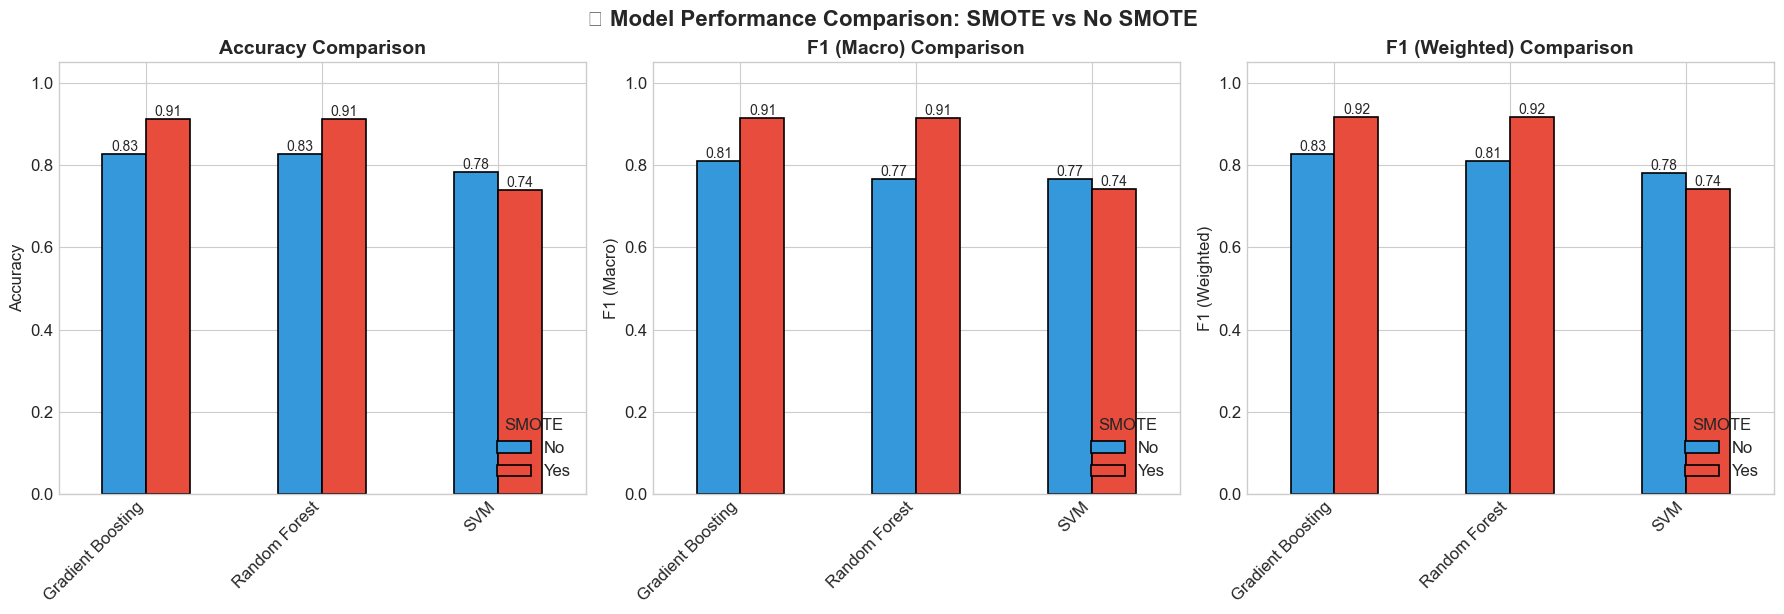

In [19]:
# Visualization: Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)']
colors_smote = {'No': '#3498db', 'Yes': '#e74c3c'}

for i, metric in enumerate(metrics):
    ax = axes[i]
    pivot = results_df.pivot(index='Model', columns='SMOTE', values=metric)
    pivot.plot(kind='bar', ax=ax, color=[colors_smote['No'], colors_smote['Yes']],
               edgecolor='black', linewidth=1.2)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1.05)
    ax.legend(title='SMOTE', loc='lower right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.tight_layout()
plt.suptitle('🏆 Model Performance Comparison: SMOTE vs No SMOTE', fontsize=16, fontweight='bold', y=1.02)
plt.show()

---
## 7. Confusion Matrices

In [20]:
# Best Model Selection
best_row = results_df.loc[results_df['F1 (Macro)'].idxmax()]
print(f"🏆 Best Model: {best_row['Model']} (SMOTE: {best_row['SMOTE']})")
print(f"   Accuracy: {best_row['Accuracy']:.4f}")
print(f"   F1 Macro: {best_row['F1 (Macro)']:.4f}")

🏆 Best Model: Random Forest (SMOTE: Yes)
   Accuracy: 0.9130
   F1 Macro: 0.9141


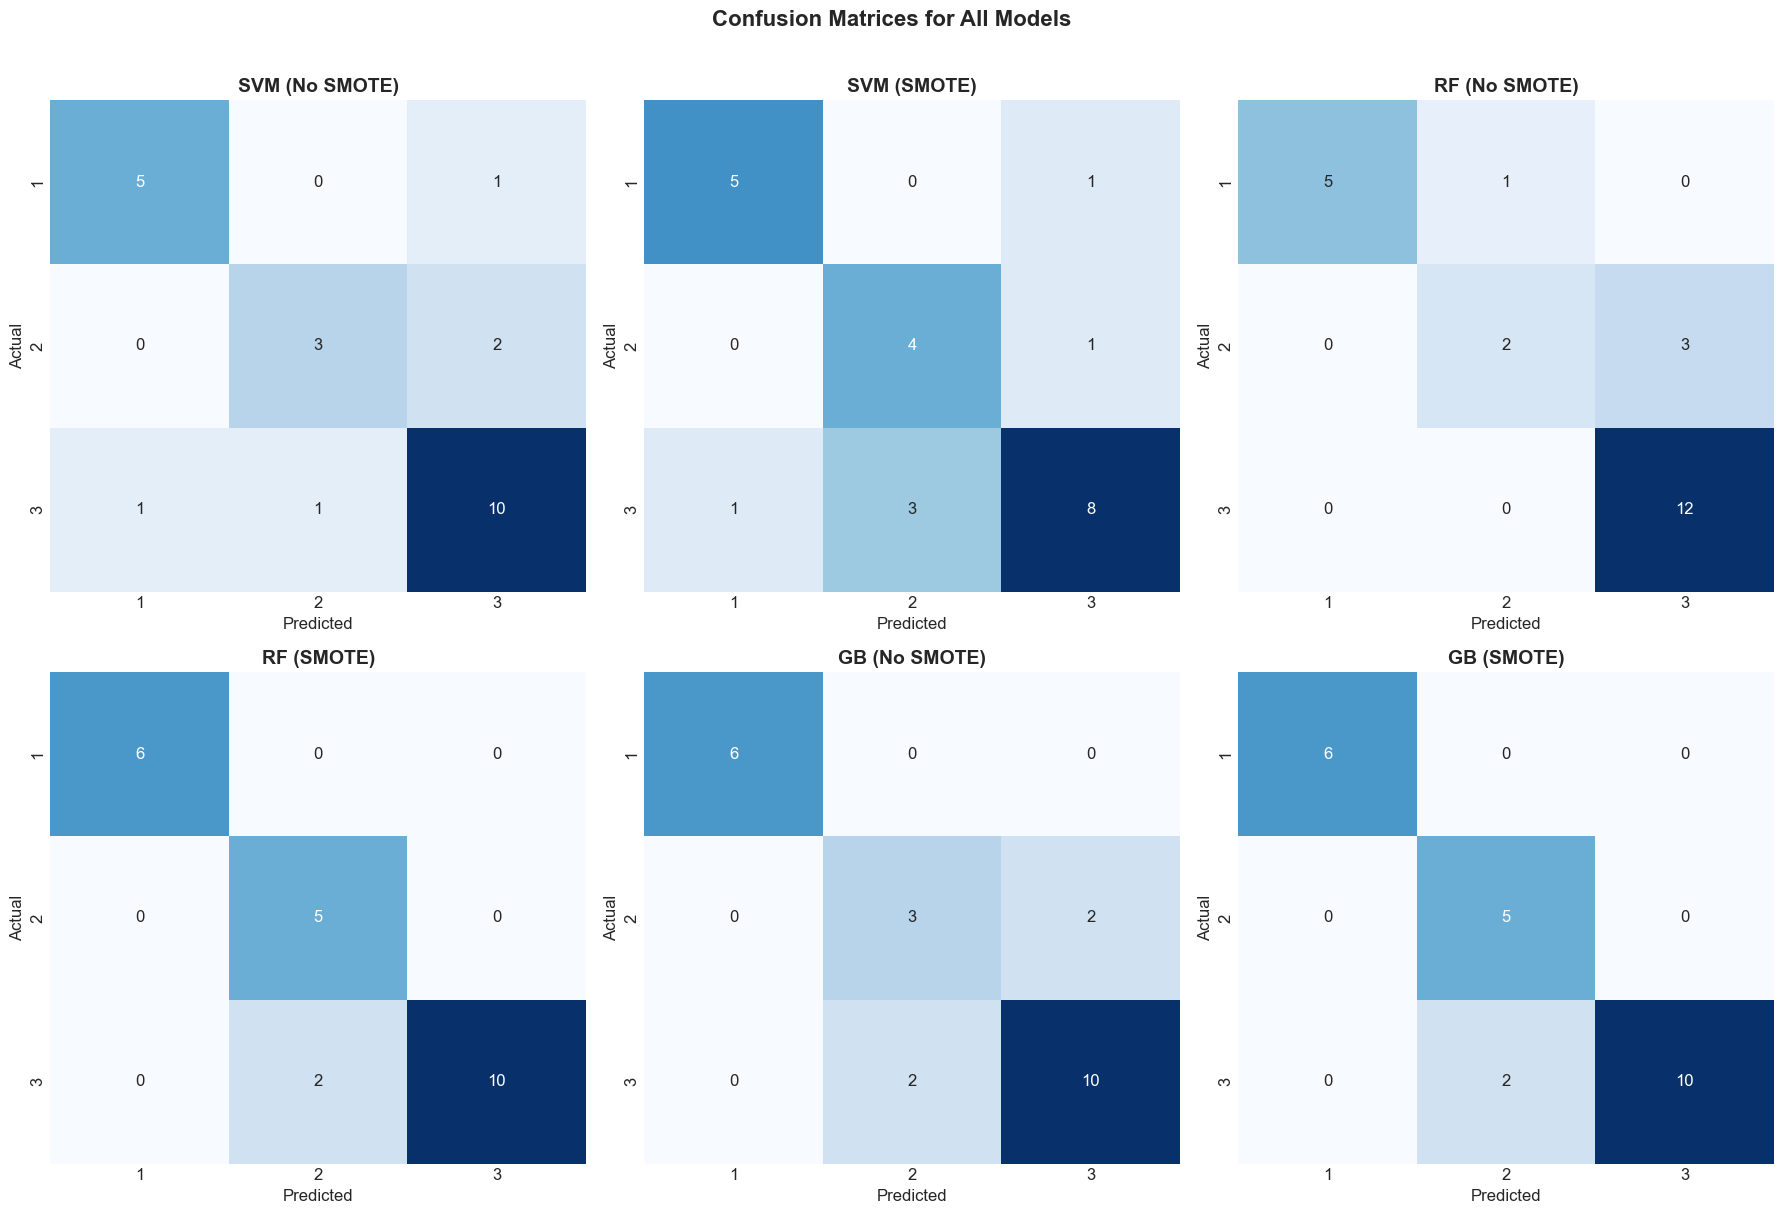

In [21]:
# Plot confusion matrices for all models
predictions = {
    'SVM (No SMOTE)': svm_pred,
    'SVM (SMOTE)': svm_pred_smote,
    'RF (No SMOTE)': rf_pred,
    'RF (SMOTE)': rf_pred_smote,
    'GB (No SMOTE)': gb_pred,
    'GB (SMOTE)': gb_pred_smote
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=[1, 2, 3], yticklabels=[1, 2, 3], cbar=False)
    axes[idx].set_title(name, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 8. Multi-class ROC-AUC Curves

In [22]:
def plot_multiclass_roc(model, X_test, y_test, model_name, ax):
    """Plot One-vs-Rest ROC curves for a multi-class classifier."""
    classes = [1, 2, 3]
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    class_names = ['Non-squeezing', 'Minor', 'Severe']
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=colors[i], lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}', fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

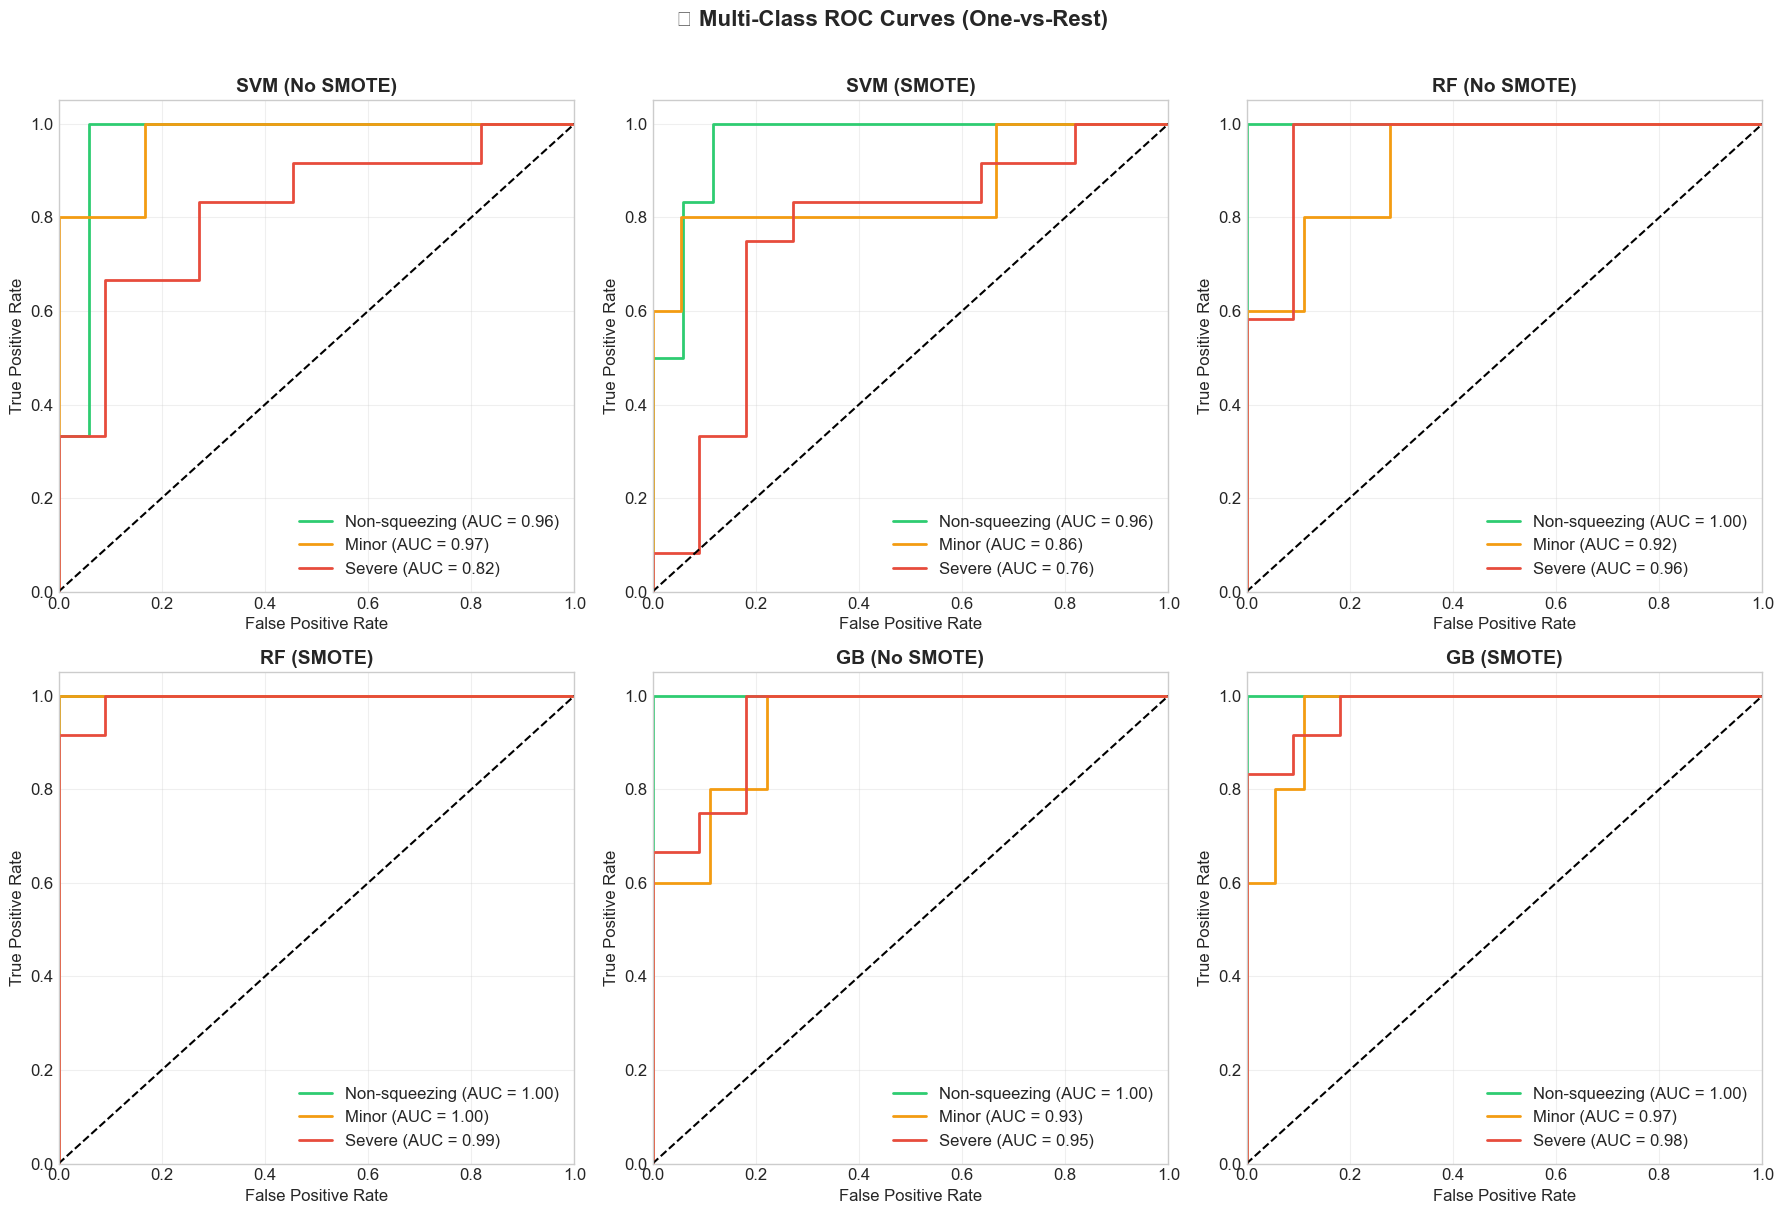

In [23]:
# Plot ROC curves for all models
models_for_roc = {
    'SVM (No SMOTE)': svm_model,
    'SVM (SMOTE)': svm_model_smote,
    'RF (No SMOTE)': rf_model,
    'RF (SMOTE)': rf_model_smote,
    'GB (No SMOTE)': gb_model,
    'GB (SMOTE)': gb_model_smote
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_for_roc.items()):
    plot_multiclass_roc(model, X_test_scaled, y_test, name, axes[idx])

plt.suptitle('📈 Multi-Class ROC Curves (One-vs-Rest)', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 9. Feature Importance (Random Forest)

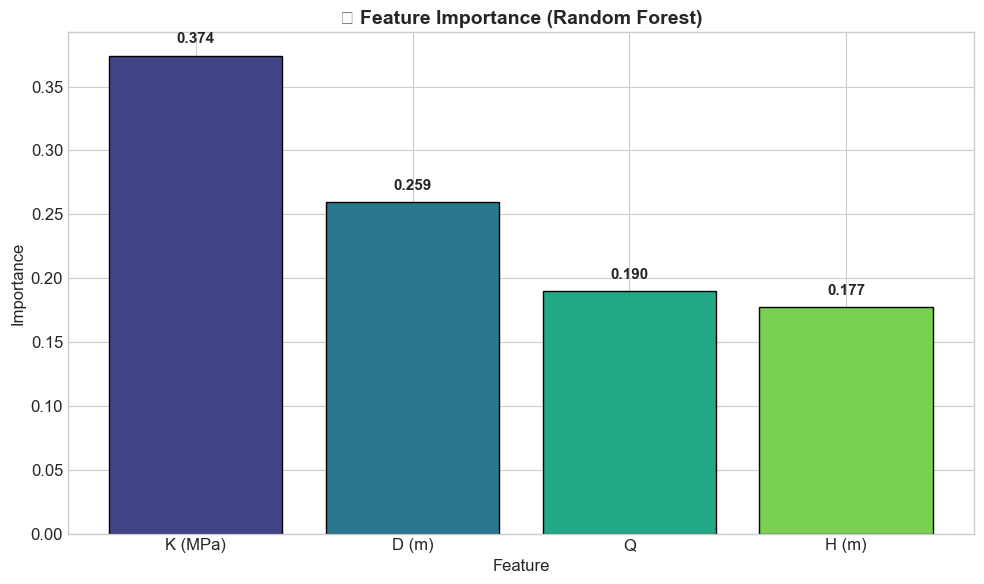

In [24]:
# Use the best RF model
best_rf = rf_model_smote if 'Yes' in best_row['SMOTE'] and 'Random Forest' in best_row['Model'] else rf_model

feature_names = ['D (m)', 'H (m)', 'Q', 'K (MPa)']
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_names)))
bars = plt.bar(range(len(feature_names)), importances[indices], color=colors, edgecolor='black')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], fontsize=12)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('🌳 Feature Importance (Random Forest)', fontweight='bold', fontsize=14)

for bar, imp in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{imp:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 10. Classification Report (Best Model)

In [25]:
# Get best model prediction
if best_row['Model'] == 'SVM' and best_row['SMOTE'] == 'Yes':
    best_pred = svm_pred_smote
elif best_row['Model'] == 'SVM' and best_row['SMOTE'] == 'No':
    best_pred = svm_pred
elif best_row['Model'] == 'Random Forest' and best_row['SMOTE'] == 'Yes':
    best_pred = rf_pred_smote
elif best_row['Model'] == 'Random Forest' and best_row['SMOTE'] == 'No':
    best_pred = rf_pred
elif best_row['Model'] == 'Gradient Boosting' and best_row['SMOTE'] == 'Yes':
    best_pred = gb_pred_smote
else:
    best_pred = gb_pred

print(f"\n📋 Classification Report for Best Model: {best_row['Model']} (SMOTE: {best_row['SMOTE']})\n")
print(classification_report(y_test, best_pred, target_names=['Non-squeezing', 'Minor', 'Severe']))


📋 Classification Report for Best Model: Random Forest (SMOTE: Yes)

               precision    recall  f1-score   support

Non-squeezing       1.00      1.00      1.00         6
        Minor       0.71      1.00      0.83         5
       Severe       1.00      0.83      0.91        12

     accuracy                           0.91        23
    macro avg       0.90      0.94      0.91        23
 weighted avg       0.94      0.91      0.92        23



---
## 11. Summary & Conclusion

This analysis compared **SVM**, **Random Forest**, and **Gradient Boosting** classifiers with and without **SMOTE** for handling class imbalance.

### Key Findings:
- The best performing model was identified based on F1 Macro score.
- SMOTE can help improve recall for minority classes (Class 2: Minor squeezing).
- Multi-class ROC-AUC curves provide insight into class-specific performance.

### Recommendations:
- Use the best model for deployment.
- Consider collecting more data, especially for Class 2, to further improve model accuracy.